# NMDS(非度量多尺度分析, Non-metric multidimensional scaling)

## 符号定义

## 概念
MDS在数据点间相似度给定的情况下确定这些数据点在低维空间中的表示。很明显，MDS依赖于特定的相似度计算方式，无论是采用经典MDS中使用的欧氏距离，还是采用ISOMAP中使用的最短路径距离，总是离不开距离的精确计算。但是在很多问题中，仅有次序可以获得，依赖于精确相似度计算的经典MDS方法显然无法处理这类问题。

为了设法解决这一问题，非度量多尺度分析（NMDS）被提出。NMDS关注的是次序，而非准确的相似度计算结果。对于给定的数据集，经典MDS设法使得降维后任意两个数据点之间的距离保持不变，而NMDS则保证降维后距离度量的大小顺序不发生改变（相距较远的两个点之间的距离在降维前后总是要比距离较近的两个点之间的距离要大）。

## 推导

实现NMDS最为朴素的想法就是对降维前后的距离排序结果进行监督学习，强行保证排序结果不变。但是“求序列”这一操作本身不可导，这为推导梯度下降法带来困难。

sklearn中的实现借鉴了保序回归。保序回归解决的如下问题：给定参考序列$\pmb{x}$和观测序列$\pmb{y}$，求得结果序列$\pmb{y^{\prime}}$，使得对于任意的$x_{a}$和$x_{b}$，当 $x_{a}<x_{b}$ 时有 $y^{\prime}_{a}<y^{\prime}_{b}$。对于NMDS的降维问题，给定的参考序列就是原空间中的排序结果（若距离均可计算，则直接使用距离），给定的的观测序列就是降维结果。

若降维后的序列和原空间中的序列的前后大小关系完全一致则说明得到了符合NMDS目标的解，若不完全一致，则说明没有得到符合要求的解，仍需要继续优化。通过保序回归得到的结果序列则可以作为每一次迭代的目标序列，从而实现有监督的学习。

值得注意的是，保序回归实现的是**局部的保序**，准确来说，应当是参考序列每一个单调区间内保序，但是无法保证区间间的关系保持不变。因此需要在降维结果基本正确的基础上应用上述方法。在实际应用中，需要使用经典MDS得到一个基本正确的解，然后才能使用上述方法对结果进行进一步的优化，否则结果无意义，这一结论在后续的案例中有体现。

## 算法流程

1. 按照[PCoA](../05_PCoA/PCoA.ipynb)中描述的方法计算距离矩阵
2. 由PCoA求得一个基本正确的解
3. 将原空间中的距离序列作为参考序列，降维后的距离序列作为观测序列，求得保序回归意义下的结果序列
4. 将第3步求得的结果序列作为目标序列，按照[PCoA](../05_PCoA/PCoA.ipynb)中描述的方法优化降维结果
5. 重复3、4步直至达到迭代停止条件

## 参考资料

https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html

https://zhuanlan.zhihu.com/p/88623159

In [1]:
import numpy as np
from scipy import linalg
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.isotonic import IsotonicRegression

In [2]:
class MyNMDS(object):

    def __init__(self, input_data, reduction_dims):
        self.input_data = input_data
        self.reduction_dims = reduction_dims

        self.samples_num, self.input_dims = self.input_data.shape

        # distance mat
        self.distance_mat = np.zeros((self.samples_num, self.samples_num))
        # distance list
        self.distance_flat = None
        self.distance_flat_w = None

        # reduction result
        self.output_mat = np.zeros((self.samples_num, reduction_dims))

    def __call__(self, distance_type="l2", iter_num=1000, min_loss=1e-3, lr=1e-3):
        self._cal_distance_mat(distance_type)
        self._iter_main(iter_num, min_loss, lr)

        return self.output_mat
    
    def _cal_distance_mat(self, distance_type="l2"):
        if distance_type == "l2":
            self.distance_mat = np.power(squareform(pdist(self.input_data, metric="euclidean")), 2)
        else:
            raise ValueError
        
        self.distance_flat = ((1 - np.tri(self.samples_num)) * self.distance_mat).ravel()
        self.distance_flat_w = self.distance_flat[self.distance_flat != 0]
    
    def _iter_main(self, iter_num=100, min_loss=1e-3, lr=1e-3, seed=1024):

        # ------------------------- classical MDS ---------------------------
        classical_mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, n_init=1, random_state=seed)
        self.output_mat = classical_mds.fit_transform(self.input_data)

        # ------------------------- NMDS ------------------------------------

        # monotonic regression
        ir = IsotonicRegression()

        iter_done = False

        iter_loop = 0

        while not iter_done:

            reduction_distance_mat = np.power(squareform(pdist(self.output_mat, metric="euclidean")), 2)
            arm_mat = self._cal_arm_mat(ir, reduction_distance_mat)
            temp_reduction_mat = self.output_mat.copy()

            # update loop
            for i in range(self.samples_num):
                self.output_mat[i, :] -= lr * np.matmul((reduction_distance_mat[i, :] - arm_mat[i, :]).reshape(1, -1), np.tile(temp_reduction_mat[i, :].reshape(1, -1), (self.samples_num, 1)) - temp_reduction_mat).reshape(-1)
            
            mds_loss = np.mean(np.power(reduction_distance_mat - arm_mat, 2))
            if iter_loop == iter_num or mds_loss <= min_loss:
                iter_done = True
            elif iter_loop % 100 == 0:
                print("steps:{} \t loss: {:.4f}".format(iter_loop, mds_loss))
            iter_loop += 1
    
    def _cal_arm_mat(self, ir, reduction_dis_mat):

        reduction_dis_mat_flat = reduction_dis_mat.ravel()
        reduction_dis_mat_flat_w = reduction_dis_mat_flat[self.distance_flat != 0]

        # calculate arm sequency
        arm_sequency = ir.fit_transform(self.distance_flat_w, reduction_dis_mat_flat_w)

        # calculatr arm mat
        arm_mat = np.zeros(self.samples_num * self.samples_num)
        arm_mat[self.distance_flat != 0] = arm_sequency
        arm_mat = arm_mat.reshape((self.samples_num, self.samples_num))
        arm_mat = arm_mat + arm_mat.T
        # normalize
        arm_mat *= np.sqrt((self.samples_num * (self.samples_num - 1) / 2) / (arm_mat ** 2).sum())

        return arm_mat

steps:0 	 loss: 2.9664
steps:100 	 loss: 0.0510
steps:200 	 loss: 0.0510
steps:300 	 loss: 0.0510


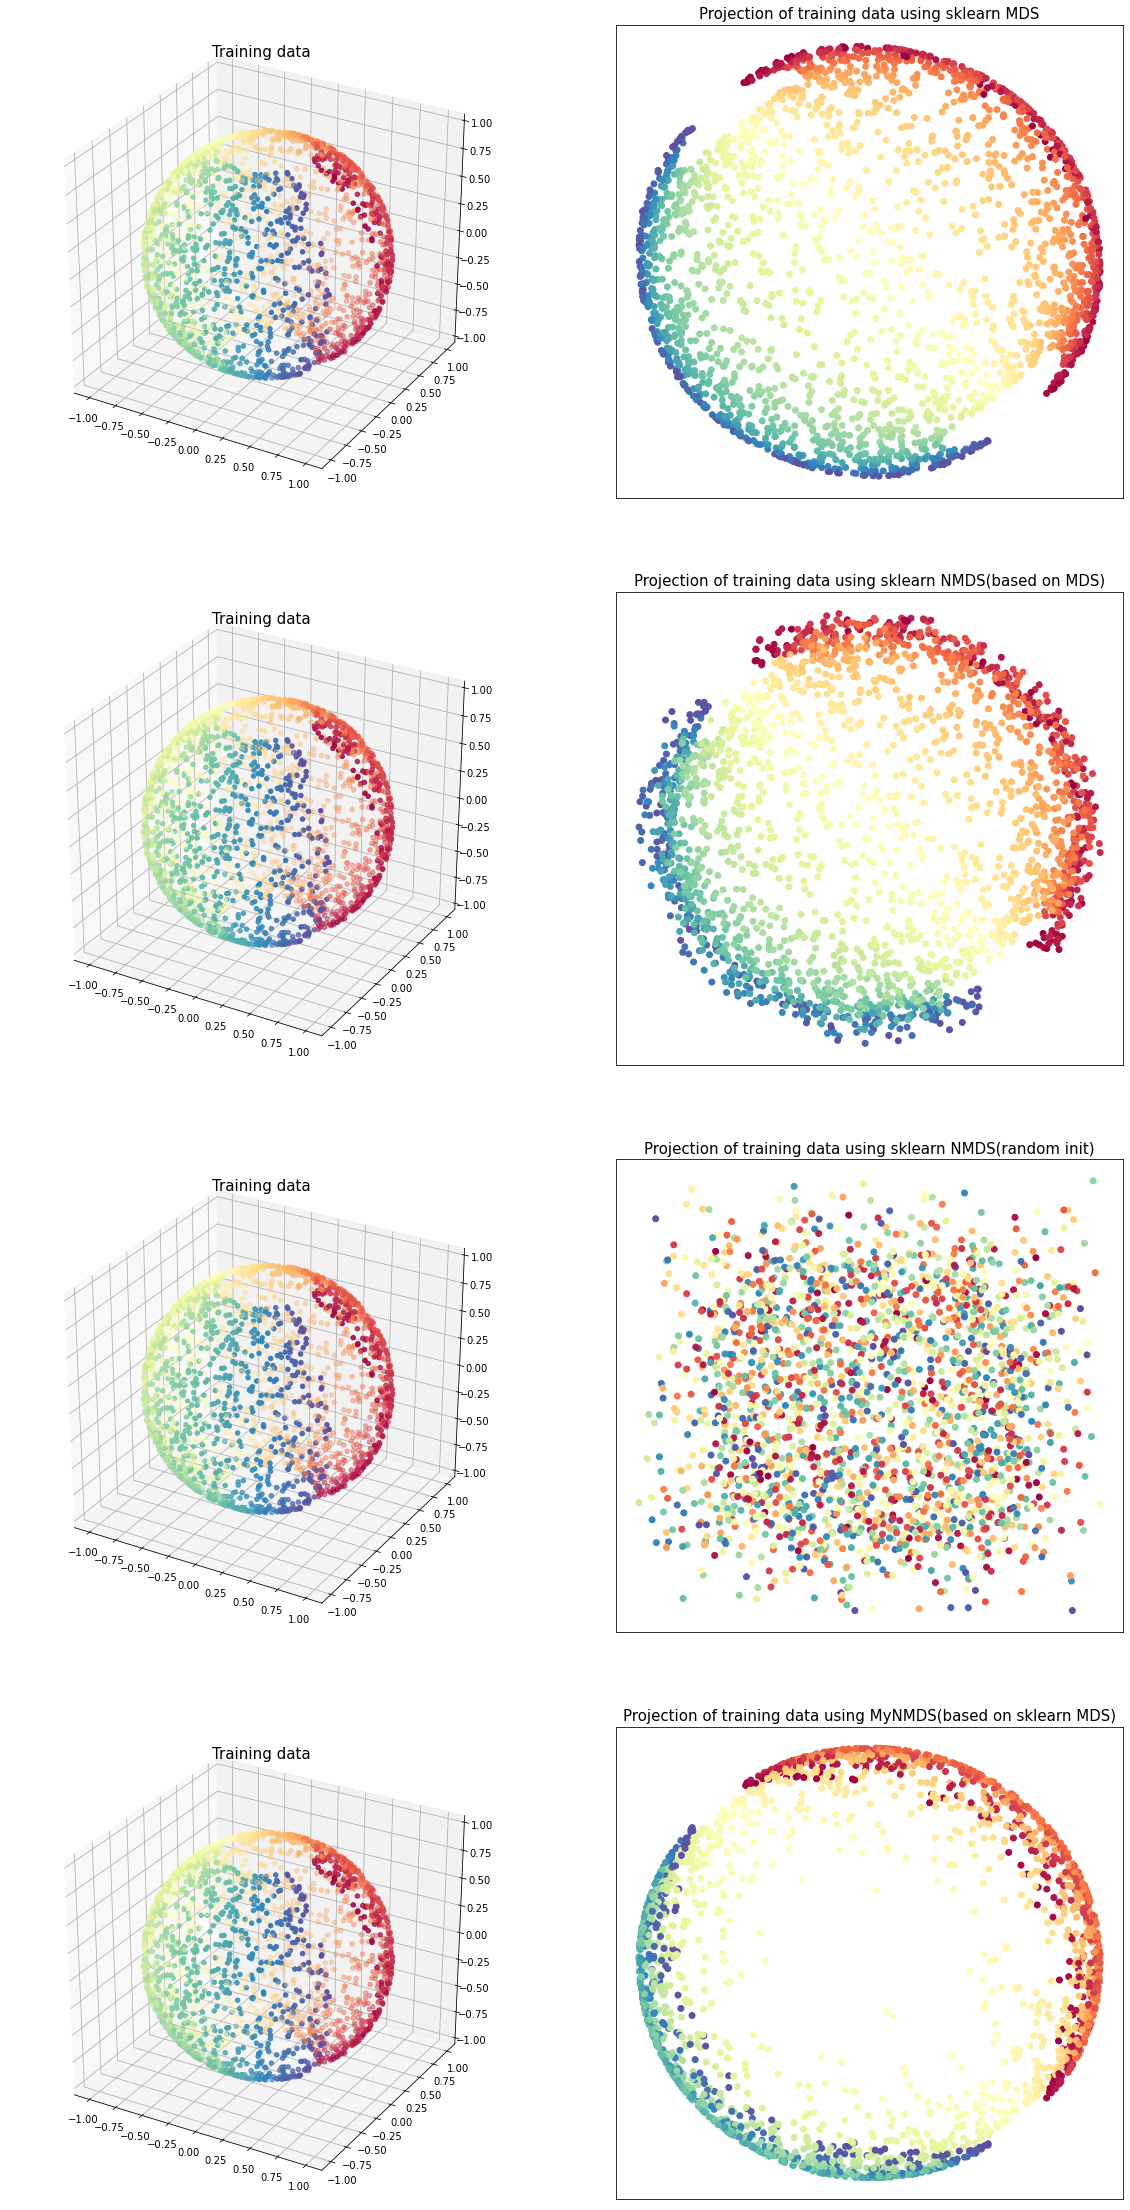

In [3]:
# ---------------------- create data ----------------------
n_samples = 3000

# Create our sphere.
np.random.seed(1024)
p = np.random.rand(n_samples) * (2 * np.pi - 0.55)
t = np.random.rand(n_samples) * np.pi

# Sever the poles from the sphere.
indices = (t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8)))
samples_color = p[indices]
x, y, z = (
    np.sin(t[indices]) * np.cos(p[indices]),
    np.sin(t[indices]) * np.sin(p[indices]),
    np.cos(t[indices]),
)
raw_samples = np.array([x, y, z]).T

# --------------------- sklearn NMDS ------------------------
sklearn_mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, n_init=1, random_state=1024)
sklearn_mds_result = sklearn_mds.fit_transform(raw_samples)

sklearn_nmds = manifold.MDS(n_components=2, metric=False, eps=1e-12, max_iter=3000, n_init=1, random_state=1024)
sklearn_nmds_result_based_on_mds = sklearn_nmds.fit_transform(raw_samples, init=sklearn_mds_result)
sklearn_nmds_result = sklearn_nmds.fit_transform(raw_samples)

# -------------------- My NMDS ------------------------------
my_nmds = MyNMDS(input_data=raw_samples, reduction_dims=2)

my_nmds_result = my_nmds(iter_num=400, lr=4e-5)

# ----------------------
# draw func
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(421, projection="3d")
ax.set_title("Training data", fontsize=15)
ax.scatter(raw_samples[:, 0], raw_samples[:, 1], raw_samples[:, 2], c=samples_color, cmap=plt.cm.Spectral)

ax = fig.add_subplot(422)
plt.xticks([])
plt.yticks([])
plt.title("Projection of training data using sklearn MDS", fontsize=15)
ax.scatter(sklearn_mds_result[:, 0], sklearn_mds_result[:, 1], c=samples_color, cmap=plt.cm.Spectral)

ax = fig.add_subplot(423, projection="3d")
ax.set_title("Training data", fontsize=15)
ax.scatter(raw_samples[:, 0], raw_samples[:, 1], raw_samples[:, 2], c=samples_color, cmap=plt.cm.Spectral)

ax = fig.add_subplot(424)
plt.xticks([])
plt.yticks([])
plt.title("Projection of training data using sklearn NMDS(based on MDS)", fontsize=15)
ax.scatter(sklearn_nmds_result_based_on_mds[:, 0], sklearn_nmds_result_based_on_mds[:, 1], c=samples_color, cmap=plt.cm.Spectral)

ax = fig.add_subplot(425, projection="3d")
ax.set_title("Training data", fontsize=15)
ax.scatter(raw_samples[:, 0], raw_samples[:, 1], raw_samples[:, 2], c=samples_color, cmap=plt.cm.Spectral)

ax = fig.add_subplot(426)
plt.xticks([])
plt.yticks([])
plt.title("Projection of training data using sklearn NMDS(random init)", fontsize=15)
ax.scatter(sklearn_nmds_result[:, 0], sklearn_nmds_result[:, 1], c=samples_color, cmap=plt.cm.Spectral)

ax = fig.add_subplot(427, projection="3d")
ax.set_title("Training data", fontsize=15)
ax.scatter(raw_samples[:, 0], raw_samples[:, 1], raw_samples[:, 2], c=samples_color, cmap=plt.cm.Spectral)

ax = fig.add_subplot(428)
plt.xticks([])
plt.yticks([])
plt.title("Projection of training data using MyNMDS(based on sklearn MDS)", fontsize=15)
ax.scatter(my_nmds_result[:, 0], my_nmds_result[:, 1], c=samples_color, cmap=plt.cm.Spectral)

plt.show()